Text analytics


####  Functions to support text analytics of imdb reviews


In [2]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations
from ggplot import *
import unicodedata
from textblob import TextBlob
import nltk
from itertools import izip
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

%matplotlib inline 
matplotlib.style.use('ggplot') 

In [3]:
# Modules to support text analytics 

def requestPage(url): 
    try:
        response = requests.get(url)  
        page  = BeautifulSoup(response.text, 'html.parser')
        return page
        
    except(ConnectionError, Exception), e:
        print "Exception is :", e

        
def extractRatings(page,i):
    data_rating = {}
    i = i + 1 
    for b in page.select('div[id="tn15content"] img'):
        rating = b.get("alt")
        if rating is not None and rating != u"[Next]" and rating != u"[Prev]":
            data_rating.update({i:rating.encode('utf-8')})
            i = i + 1
    return data_rating

def extractReviews(page,i):
    data_review = {}
    i = i + 1 
    for a in page.select('div[id="tn15content"] p'):
        review = a.get_text().replace("\n"," ").replace("*** This review may contain spoilers ***", "IGNORE").replace("Add another review","IGNORE")
        if review != "IGNORE":
            data_review.update({i:review.encode('utf-8')})
            i = i + 1 
    return data_review

def tokenize(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

### Extract IMDB movie reviews ( 50 positive , 50 negative ) for movie = Titanic ( 1997 ) 
   http://www.imdb.com/title/tt0120338/
    

In [4]:
# Movie name = Up

p_url = "http://www.imdb.com/title/tt0120338/reviews?filter=love;start=" # positive reviews link
n_url = "http://www.imdb.com/title/tt0120338/reviews?filter=hate;start=" # negative reviews link

# DataFrame for all extracted reviews
imdb = pd.DataFrame()

# Pagination for 50 reviews 
pagination = [0,10,20,30,40] # pagination for imdb pagination to get top 50 reviews in a category 

for counter in pagination:

    positive_url = p_url + str(counter)
    negative_url = n_url + str(counter)
    
    # Request url for reviews 
    responses_positive = requestPage(positive_url)
    responses_negative = requestPage(negative_url)
    
    # Extract ratings and reviews 
    ratings_positive  = extractRatings(responses_positive,counter)    
    reviews_positive  = extractReviews(responses_positive,counter)
    
    ratings_negative  = extractRatings(responses_negative,counter+50)
    reviews_negative  = extractReviews(responses_negative,counter+50)
    
    # Copy the extracted data into dataframes
    df_p = pd.DataFrame(columns=['ratings','reviews'])
    df_p = pd.DataFrame([ratings_positive,reviews_positive]).T
    
    df_n = pd.DataFrame(columns=['ratings','reviews'])
    df_n = pd.DataFrame([ratings_negative,reviews_negative]).T
    
    # Create master dataframe for text analytics 
    imdb = imdb.append([df_p,df_n])
    
print "\n Extracted ratings & reviews"


 Extracted ratings & reviews


In [5]:
imdb.columns = ['ratings', 'reviews']
imdb = imdb.sort_index()
print imdb.head(10)
print imdb.tail(10)

   ratings                                            reviews
1    10/10   Every once in a while the conversation will t...
2    10/10    To all the miserable people who have done ev...
3    10/10    I find it so amazing that even after all the...
4    10/10   This movie re-wrote film history in every way...
5    10/10   Back in 1997, do I remember that year: Clinto...
6    10/10   James Cameron's 'Titanic' is essentially a ro...
7    10/10   It's a crying freaking shame that this outsta...
8    10/10    When you have a film this big and successful...
9    10/10   Thirteen years after Titanic launched and all...
10   10/10   Good Lord. This movie right here, it's a mast...
    ratings                                            reviews
91     1/10    I can´t see what so great with this film. Fo...
92     1/10    Alright... where to begin. This is.. without...
93     1/10   This movie is the biggest waste of an opportu...
94     1/10    This movie should have never have been nomin...
95 

In [6]:
# Convert user ratings from string to float 
temp_ratings =  imdb['ratings'].str.split('/', expand = True ).astype(float)
temp_ratings['divide'] = temp_ratings[0].div(temp_ratings[1], axis='index')
imdb['ratings'] = temp_ratings['divide']


### Identify polarity & subjectivity ( sentiment analysis ) of all movie reviews 


In [7]:
# Find polarity and subjectivity of the reviews ( sentiment analysis)

imdb['polarity'] = imdb.reviews.apply(lambda s: TextBlob(unicode(s, errors='ignore')).sentiment.polarity)
imdb['subjectivity'] = imdb.reviews.apply(lambda s: TextBlob(unicode(s, errors='ignore')).sentiment.subjectivity)
imdb.head(15)

,ratings,reviews,polarity,subjectivity
1,1.0,Every once in a while the conversation will t...,0.158136,0.558948
2,1.0,To all the miserable people who have done ev...,0.152778,0.563889
3,1.0,I find it so amazing that even after all the...,0.240171,0.453155
4,1.0,This movie re-wrote film history in every way...,0.441667,0.682143
5,1.0,"Back in 1997, do I remember that year: Clinto...",0.257593,0.607704
6,1.0,James Cameron's 'Titanic' is essentially a ro...,0.133479,0.567009
7,1.0,It's a crying freaking shame that this outsta...,0.168599,0.589010
8,1.0,When you have a film this big and successful...,0.168932,0.568299
9,1.0,Thirteen years after Titanic launched and all...,0.210227,0.517424
10,1.0,"Good Lord. This movie right here, it's a mast...",0.219643,0.628671


### Co-relation between movie review polarity and star ratings from the users 


               ratings  polarity  subjectivity
ratings       1.000000  0.631849      0.160403
polarity      0.631849  1.000000      0.141231
subjectivity  0.160403  0.141231      1.000000


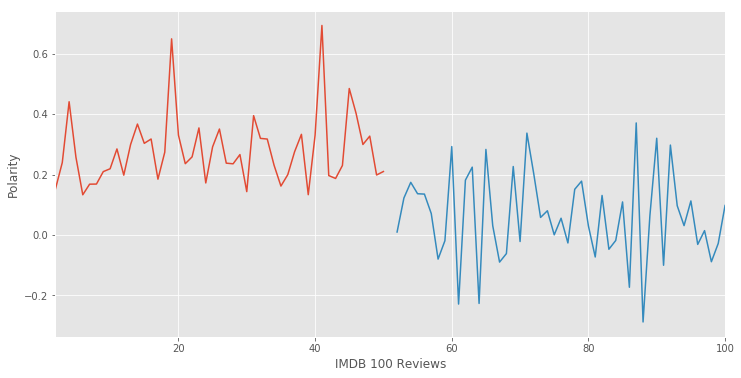

In [8]:
print imdb[['ratings','polarity','subjectivity']].corr()

ax = imdb['polarity'][1:50].plot(figsize=(12, 6))
ax = imdb['polarity'][51:100].plot(figsize=(12, 6))
ax.set_xlabel("IMDB 100 Reviews", fontsize=12)
ax.set_ylabel("Polarity", fontsize=12)
plt.show()


### Stopwords = [ NLTK stopwords + Extended words from multiple iterations of text analysis ) 

In [9]:
stop_words = nltk.corpus.stopwords.words('english')
extended_stopwords = ['\'ll','\'d','\'m','\'re','\'s','\'ve','ca n\'t','r','n\'t','ca','see','get','movies','movie','go','say','come','many','another','could','would','made','really','want','even','odd','films','plot','ever','actually','also','movie','film']
stopwords = stop_words + extended_stopwords

print stopwords

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u


###  Document Term Matrix using TF-IDF weighing scheme ( unigrams & bigrams ) 


In [10]:
term_idf_vectorizer       = TfidfVectorizer(max_df=0.9, max_features=2000,min_df=0.3, stop_words=stopwords, use_idf=True, tokenizer=tokenize, ngram_range=(1,2))
%time term_idf_matrix     = term_idf_vectorizer.fit_transform(imdb.reviews) 
term_idf_feature_names    = term_idf_vectorizer.get_feature_names()
print (term_idf_matrix).shape

CPU times: user 392 ms, sys: 12 ms, total: 404 ms
Wall time: 404 ms
(100, 23)


### TF-IDF Features on model params  ( min_df = 0.3 , max_df = 0.9 )

In [11]:
print term_idf_feature_names

tfidf = zip(term_idf_vectorizer.get_feature_names(),np.asarray(term_idf_matrix.sum(axis=0)).ravel())
term_idf_frequency = sorted(tfidf,key=lambda x: x[1],reverse=True)
term_idf_frequency

[u'best', u'cameron', u'dicaprio', u'effects', u'good', u'jack', u'james', u'james cameron', u'kate', u'like', u'love', u'love story', u'much', u'one', u'people', u'rose', u'seen', u'ship', u'special', u'story', u'time', u'titanic', u'winslet']


[(u'titanic', 23.816388065259229),
 (u'one', 17.816273201816202),
 (u'people', 16.28637155526151),
 (u'love', 15.994226712869134),
 (u'ship', 15.680991540890769),
 (u'time', 15.181084930271583),
 (u'story', 14.158611453695693),
 (u'like', 12.692362389482325),
 (u'cameron', 12.570285579352678),
 (u'rose', 12.314379553851616),
 (u'jack', 10.536474022225097),
 (u'best', 10.176133248342458),
 (u'good', 9.9813549064206892),
 (u'james', 9.9129111421178884),
 (u'love story', 9.7936953537828355),
 (u'effects', 9.7270116987082638),
 (u'much', 9.1663660037724402),
 (u'seen', 9.1566845823009686),
 (u'winslet', 8.511426163671123),
 (u'special', 8.2773013661909314),
 (u'kate', 8.2138779927123799),
 (u'dicaprio', 7.8400281414858632),
 (u'james cameron', 7.3140359337772081)]

###  Document Term Matrix using Term Frequency (TF)  weighing scheme ( unigrams & bigrams ) 

In [12]:
count_vectorizer    = CountVectorizer(max_df=0.9, max_features=2000,min_df=0.3, stop_words=stopwords, tokenizer=tokenize, ngram_range=(1,2))
%time term_frequency_matrix = count_vectorizer.fit_transform(imdb.reviews) 
term_frequency_feature_names    = count_vectorizer.get_feature_names()
print (term_frequency_matrix).shape 

CPU times: user 380 ms, sys: 28 ms, total: 408 ms
Wall time: 380 ms
(100, 23)


### Term Frequency  Features on model params  ( min_df = 0.3 , max_df = 0.9 )

In [13]:
print term_frequency_feature_names

tf = zip(count_vectorizer.get_feature_names(),np.asarray(term_frequency_matrix.sum(axis=0)).ravel())
term_frequency = sorted(tf,key=lambda x: x[1],reverse=True)
term_frequency

[u'best', u'cameron', u'dicaprio', u'effects', u'good', u'jack', u'james', u'james cameron', u'kate', u'like', u'love', u'love story', u'much', u'one', u'people', u'rose', u'seen', u'ship', u'special', u'story', u'time', u'titanic', u'winslet']


[(u'titanic', 202),
 (u'one', 123),
 (u'ship', 120),
 (u'love', 111),
 (u'story', 102),
 (u'time', 102),
 (u'rose', 89),
 (u'cameron', 85),
 (u'people', 85),
 (u'like', 72),
 (u'jack', 71),
 (u'james', 61),
 (u'effects', 56),
 (u'much', 51),
 (u'best', 49),
 (u'good', 49),
 (u'love story', 47),
 (u'special', 46),
 (u'winslet', 46),
 (u'seen', 43),
 (u'dicaprio', 42),
 (u'kate', 42),
 (u'james cameron', 41)]

### Topic extraction with Non-negative Matrix Factorization using TF-IDF Features 

In [14]:
# Fit the NMF model
%time nmf = NMF(n_components=8, random_state=1,alpha=.1, l1_ratio=.5).fit(term_idf_matrix)

print("\nFitting the Non-negative Matrix Factorization model with tf-idf features: \n")
print_top_words(nmf, term_idf_feature_names, 14)

CPU times: user 80 ms, sys: 188 ms, total: 268 ms
Wall time: 125 ms

Fitting the Non-negative Matrix Factorization model with tf-idf features: 

Topic #0:
one time like much ship seen story best cameron effects people jack james dicaprio
Topic #1:
love love story story much time good titanic cameron like jack james people best seen
Topic #2:
people seen much dicaprio story titanic jack winslet like james cameron cameron effects good james
Topic #3:
rose jack story kate ship love like winslet titanic time one much cameron dicaprio
Topic #4:
cameron james james cameron like dicaprio seen much story titanic one effects rose kate winslet
Topic #5:
best kate winslet good dicaprio like seen rose love james one james cameron cameron effects
Topic #6:
effects special good seen titanic cameron one rose people winslet james cameron dicaprio jack james
Topic #7:
titanic ship time love winslet dicaprio story jack good kate people james effects james cameron
()


### Topic extraction with Latent Dirichlet Allocation using TF Features 

In [15]:
lda = LatentDirichletAllocation(n_topics=8, max_iter=5,learning_method='online',learning_offset=50.,random_state=0)
%time lda.fit(term_frequency_matrix)
print("\nTopics using Latent Dirichlet Allocation model with Term frequencies: \n")
print_top_words(lda, term_frequency_feature_names, 14)

CPU times: user 184 ms, sys: 0 ns, total: 184 ms
Wall time: 183 ms

Topics using Latent Dirichlet Allocation model with Term frequencies: 

Topic #0:
titanic ship one time love story people rose jack like cameron best james much
Topic #1:
rose kate winslet time people ship james story love dicaprio seen james cameron jack good
Topic #2:
people rose ship time jack story one dicaprio much love story special like titanic seen
Topic #3:
best one much like cameron james time james cameron story people love dicaprio kate love story
Topic #4:
love story rose titanic winslet one special jack effects ship dicaprio seen kate time
Topic #5:
like cameron much one time titanic good kate james james cameron winslet jack people effects
Topic #6:
titanic cameron effects story special love james love story one james cameron seen rose good ship
Topic #7:
jack rose love kate titanic story dicaprio winslet time love story much special people one
()


###  LDA Topic modeling using only Bigram features  based on frequency ( avoid unigram noise ) 

In [16]:
bigram_vectorizer    = CountVectorizer(max_df=0.9, max_features=200,min_df=0.06, stop_words=stopwords, tokenizer=tokenize, ngram_range=(2,3))
%time dtm_bigram_matrix = bigram_vectorizer.fit_transform(imdb.reviews) 
bigram_frequency_feature_names    = bigram_vectorizer.get_feature_names()
print (dtm_bigram_matrix).shape
print ("\n Bigram Features based on Term Frequency \n ")
tf = zip(bigram_vectorizer.get_feature_names(),np.asarray(dtm_bigram_matrix.sum(axis=0)).ravel())
bigram_term_frequency = sorted(tf,key=lambda x: x[1],reverse=True)
bigram_term_frequency

CPU times: user 412 ms, sys: 16 ms, total: 428 ms
Wall time: 403 ms
(100, 22)

 Bigram Features based on Term Frequency 
 


[(u'love story', 47),
 (u'james cameron', 41),
 (u'special effects', 41),
 (u'kate winslet', 29),
 (u'jack rose', 25),
 (u'leonardo dicaprio', 20),
 (u'billy zane', 16),
 (u'first time', 13),
 (u'james horner', 12),
 (u'celine dion', 11),
 (u'jack dawson', 11),
 (u'kathy bates', 11),
 (u'sinking ship', 10),
 (u'every time', 8),
 (u'historically accurate', 8),
 (u'ship sinking', 8),
 (u'bill paxton', 7),
 (u'gloria stuart', 7),
 (u'dicaprio kate', 6),
 (u'dicaprio kate winslet', 6),
 (u'dicaprio winslet', 6),
 (u'much money', 6)]

In [16]:
#from IPython.display import Image
#Image(filename='up_imdb_review.png')

###  Topics = 5 , Displaying top 10 words based on probability 

In [17]:
lda = LatentDirichletAllocation(n_topics=5, max_iter=4,learning_method='batch',learning_offset=50.,random_state=0)
%time lda.fit(dtm_bigram_matrix)
print("\nTopics using Latent Dirichlet Allocation model with Term frequencies: \n")
print_top_words(lda, bigram_frequency_feature_names,12)

CPU times: user 76 ms, sys: 8 ms, total: 84 ms
Wall time: 85.7 ms

Topics using Latent Dirichlet Allocation model with Term frequencies: 

Topic #0:
special effects love story kate winslet leonardo dicaprio jack dawson jack rose historically accurate first time bill paxton every time sinking ship gloria stuart
Topic #1:
jack rose james cameron dicaprio winslet gloria stuart kathy bates love story much money special effects ship sinking leonardo dicaprio first time jack dawson
Topic #2:
special effects every time james cameron james horner leonardo dicaprio dicaprio winslet ship sinking jack rose first time bill paxton gloria stuart kate winslet
Topic #3:
love story james cameron celine dion james horner first time much money jack dawson billy zane kate winslet kathy bates gloria stuart bill paxton
Topic #4:
kate winslet billy zane james cameron special effects leonardo dicaprio sinking ship kathy bates dicaprio kate winslet dicaprio kate ship sinking dicaprio winslet historically accur

###  Recommendation based on movie attributes [ Titanic( 1997)  ] 

    [ Floating house, Paradise falls, Thousands Balloons, Old man & Boy , Retirement Home flying to South America, Boy scout, bird = Kevin ] 
     
     Very innovative animation movie ( may be better than toy story ) which will attract young and old because of its characters. The director needs to retain the theme where he effectively utilized talking animals, explorer , adventures, bonding ( young kid with old man ) which got him success. 
     
     Pixar , Disney should make more animation movies with actors Edward Asner , Christopher Plummer & Jordan Nagai
    